# Imports

In [53]:
import pandas as pd
import numpy as np
import re
import datetime
import pytz

import matplotlib.pyplot as plt
import plotly.express as px
import seawater as sw

import geopandas as gpd
from shapely.geometry import Point, LineString
from rasterio.plot import show
import rasterio

import plotly.graph_objects as go
from plotly.subplots import make_subplots

from scipy.interpolate import griddata 
import scipy.interpolate as si

In [9]:
# Caminho do basemap
basemap_path = 'basemap_cNautica.tif'
basemap = rasterio.open(basemap_path)

# Leitura do arquivo GPX

In [10]:
GPXfile = 'GPS_20210227.gpx'
with open(GPXfile, 'r') as f:
    data = f.read()

# Extrair latitudes, longitudes e tempo do arquivo GPX
lat = np.array(re.findall(r'lat="([^"]+)', data), dtype=float)
lon = np.array(re.findall(r'lon="([^"]+)', data), dtype=float)
time = re.findall(r'<time>([^\<]+)', data)

# Filtrar latitudes e longitudes pela área de interesse
LAT = lat[lat < -32]
LON = lon[lon < -52]

# Montar o tempo em UTC
tempo = [datetime.datetime.strptime(t, "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=datetime.timezone.utc) for t in time]

# Juntar as coordenadas com o tempo em um DataFrame
gps_df = pd.DataFrame({'lat': LAT, 'lon': LON, 'tempo': tempo})

# Remover dados do dia 25/02/2021
gps_df = gps_df[gps_df['tempo'].dt.date != datetime.date(2021, 2, 25)]

# Converter o fuso horário de UTC para Local
tz_SP = pytz.timezone('America/Sao_Paulo')
gps_df['tempo'] = gps_df['tempo'].dt.tz_convert(tz_SP)

# Remover a primeira linha que possui dados ruins
gps_df.drop(0, inplace=True)

# Resetar o índice
gps_df.reset_index(drop=True, inplace=True)

# Visualização dos primeiros registros do DataFrame
print("Dados GPS:")
display(gps_df.head())

Dados GPS:


lat        lon                     tempo
0 -32.136324 -52.102307 2021-02-26 07:54:17-03:00
1 -32.136302 -52.102142 2021-02-26 07:54:22-03:00
2 -32.136332 -52.102094 2021-02-26 07:54:28-03:00
3 -32.136321 -52.101962 2021-02-26 07:54:33-03:00
4 -32.136319 -52.101864 2021-02-26 07:54:38-03:00

### Visualizando os dados

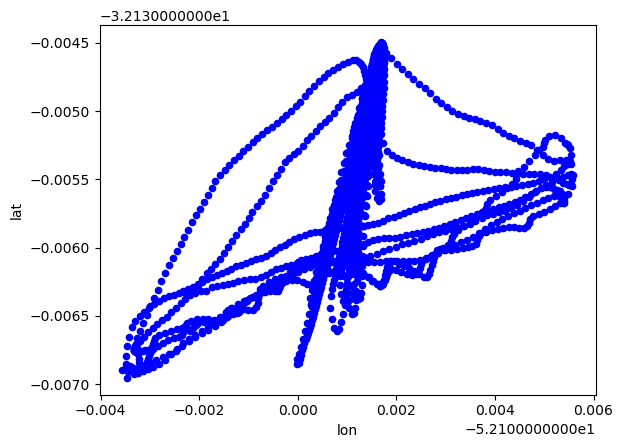

In [11]:
gps_df.plot.scatter(x='lon', y='lat', c='b');

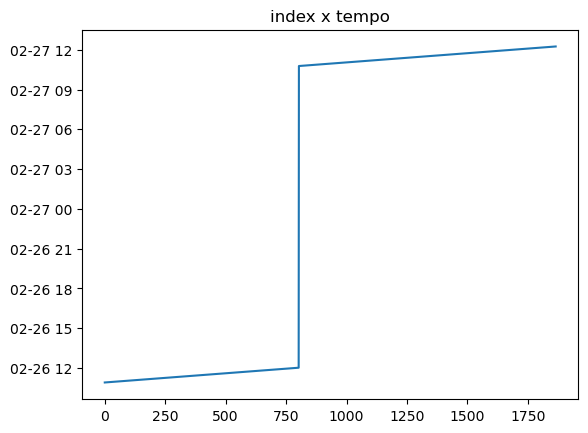

In [12]:
gps_df.tempo.plot(title='index x tempo');

# Leitura do arquivo CSV de CTD

In [13]:
CTDfile = '202102270755_ASTD152-ALC-R02_0237_075509.Csv'

# Definir a string que indica o início dos dados
string_inicio_dados = '[Item]\n'

# Ler o arquivo CSV como uma lista de strings
with open(CTDfile, 'r') as f:
    linhas = f.readlines()

# Encontrar o índice da linha que contém a string de início dos dados
indice_inicio_dados = linhas.index(string_inicio_dados)

# Nomes originais das colunas
col_nomes_orig = linhas[indice_inicio_dados+1]

# Novos nomes das colunas
c = ['tempo','pressao', 'temperatura', 'salinidade', 'condutividade', 'ec', 'densidade', 
     'sigmat', 'chlflu', 'chla', 'turbidez', 'do%', 'domgl', 'dommoll', 'bateria']

ctd_df = pd.read_csv(CTDfile, header=indice_inicio_dados+1, sep=',', index_col=False, names=c)

# Renomear a última coluna para 'Depth [m]'
#ctd_df.rename(columns={ctd_df.columns[-1]: 'Depth [m]'}, inplace=True)

# Remover as linhas com NaN na coluna 'Depth [m]'
#ctd_df.dropna(subset=['Depth [m]'], inplace=True)

# Ajuste do tipo de dados da coluna 'Datetime'
ctd_df['tempo'] = pd.to_datetime(ctd_df['tempo'])

# Definir o fuso horário desejado
tz_SP = 'America/Sao_Paulo'

# Adicionar a informação de fuso horário ao tempo de CTD
ctd_df['tempo'] = ctd_df['tempo'].dt.tz_localize(tz=None)  # Removendo o fuso horário etistente (se houver)
ctd_df['tempo'] = ctd_df['tempo'].dt.tz_localize(tz_SP)  # Definindo o fuso horário desejado

# Remover colunas não utilizadas
col_to_drop = ['condutividade', 'ec', 'densidade', 'sigmat', 'chlflu', 'chla', 'do%', 'domgl', 'dommoll', 'bateria']
CTD_df = ctd_df.drop(columns=col_to_drop)

# Visualização dos primeiros registros do DataFrame
print("\nDados CTD:")
display(CTD_df.head())


Dados CTD:


tempo  pressao  temperatura  salinidade  turbidez
0 2021-02-27 07:55:15-03:00   -1.245       24.985       0.015      1.57
1 2021-02-27 07:55:15-03:00   -1.245       24.990       0.015      1.46
2 2021-02-27 07:55:15-03:00   -1.245       24.990       0.015      2.37
3 2021-02-27 07:55:15-03:00   -1.245       24.989       0.015      3.13
4 2021-02-27 07:55:15-03:00   -1.245       24.984       0.015      3.08

### Visualizando os perfis verticais

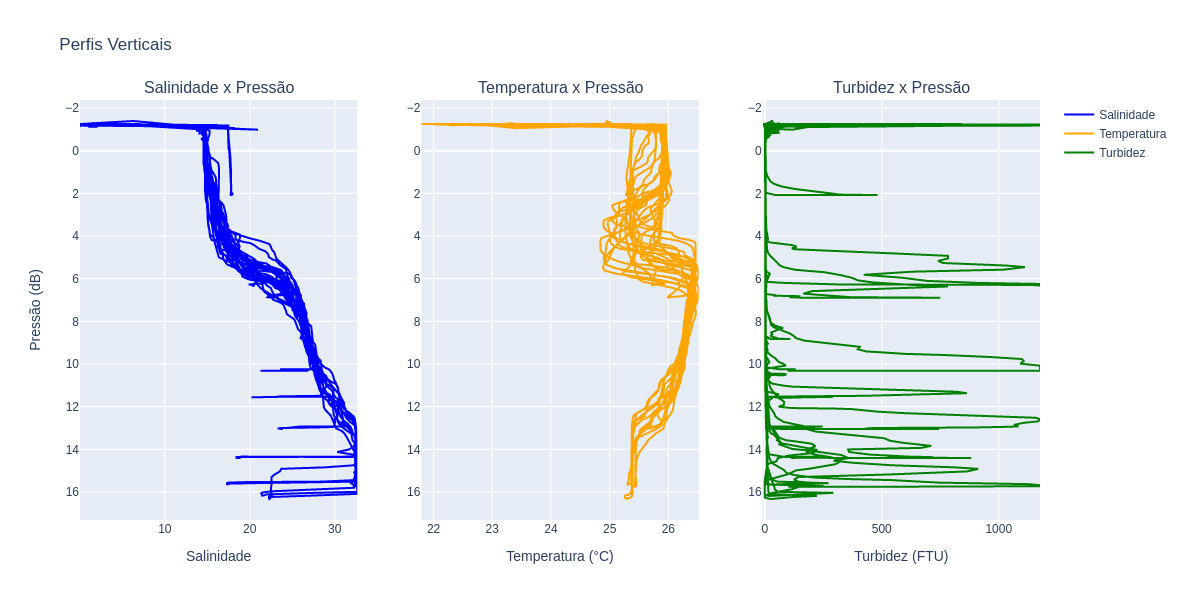

In [14]:
# Criar subplots
fig = make_subplots(rows=1, cols=3, shared_yaxes=True, subplot_titles=('Salinidade x Pressão', 'Temperatura x Pressão', 'Turbidez x Pressão'))

# Adicionar perfil de salinidade x pressão
fig.add_trace(go.Scatter(x=CTD_df['salinidade'], y=CTD_df['pressao'], mode='lines', name='Salinidade',
                         line=dict(color='blue')), row=1, col=1)
fig.update_xaxes(title_text="Salinidade", row=1, col=1)
fig.update_yaxes(title_text="Pressão (dB)", autorange="reversed", row=1, col=1)

# Adicionar perfil de temperatura x pressão
fig.add_trace(go.Scatter(x=CTD_df['temperatura'], y=CTD_df['pressao'], mode='lines', name='Temperatura',
                         line=dict(color='orange')), row=1, col=2)
fig.update_xaxes(title_text="Temperatura (°C)", row=1, col=2)
fig.update_yaxes(autorange="reversed", showticklabels=True, row=1, col=2)

# Adicionar perfil de turbidez x pressão
fig.add_trace(go.Scatter(x=CTD_df['turbidez'], y=CTD_df['pressao'], mode='lines', name='Turbidez',
                         line=dict(color='green')), row=1, col=3)
fig.update_xaxes(title_text="Turbidez (FTU)", row=1, col=3)
fig.update_yaxes(autorange="reversed", showticklabels=True, row=1, col=3)

# Atualizar layout do gráfico
fig.update_layout(height=600, width=1000, title_text="Perfis Verticais")

# Mostrar o gráfico
fig.show()

# Sincronizando GPS e CTD temporalmente

In [15]:
CTD_df.set_index('tempo', inplace=True)

first_occurrence = None
n_ocorrencias = []
c = 0


for idx in CTD_df.index:
    if first_occurrence is None or idx != first_occurrence:
        n_ocorrencias.append(c)
        first_occurrence = idx
        c = 1
    else:
        c += 1

n = n_ocorrencias[1:]
n.append(10)

In [18]:
n_indice = []

for i, u in enumerate(CTD_df.index.unique()):
    if n[i] == 10:
         t_increment = pd.Timedelta(0)
    else:
         t_increment = pd.Timedelta(100000000 * (n[i]))
    for j in range(n[i]):
        n_indice.append(u + t_increment)
        t_increment += pd.Timedelta(milliseconds=100)

In [19]:
# Converter a lista de timestamps em um objeto pandas Datetime
datetime_indice = pd.to_datetime(n_indice)

# Atribuir os novos índices ao DataFrame
CTD_df.index = pd.Index(datetime_indice, name='tempo')

CTD_df.reset_index(inplace=True)

In [20]:
# First, ensure that both DataFrames have datetime indices
gps_df.set_index('tempo', inplace=True)
CTD_df.set_index('tempo', inplace=True)

# Resample the DataFrame to 10Hz (every 0.1 seconds)
gps_df_resampled = gps_df.resample('0.1S').asfreq()

# Interpolate the resampled DataFrame
gps_df_interp = gps_df_resampled.interpolate(method='linear')

# Get the start and end datetimes from CTD_df
start_datetime = CTD_df.index.min()
end_datetime = CTD_df.index.max()

# Slice the gps_df DataFrame to start and end at the same datetimes as CTD_df
gps_df_sliced = gps_df_interp.loc[start_datetime:end_datetime]

# Reset the index
gps_df_sliced.reset_index(inplace=True)
CTD_df.reset_index(inplace=True)

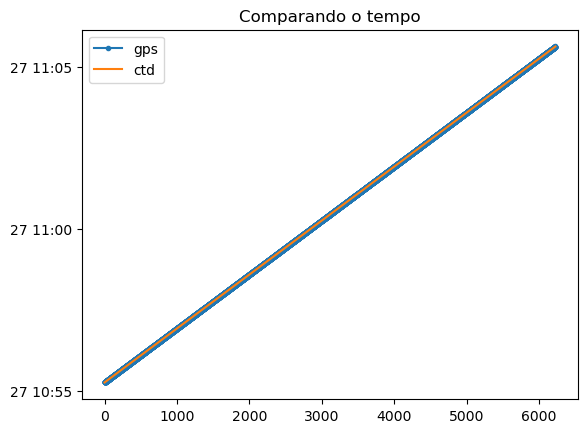

In [21]:
plt.plot(gps_df_sliced.tempo, label='gps', marker='.')
plt.plot(CTD_df.tempo, label='ctd')
plt.legend()
plt.title('Comparando o tempo')
plt.show()

In [22]:
# Mesclar os DataFrames com base na coluna de tempo
dados_df = pd.merge(CTD_df, gps_df_sliced, on='tempo')

# Etibir o DataFrame mesclado
display(dados_df.head())

tempo  pressao  temperatura  salinidade  \
0 2021-02-27 07:55:15.500000-03:00   -1.245       24.985       0.015   
1 2021-02-27 07:55:15.600000-03:00   -1.245       24.990       0.015   
2 2021-02-27 07:55:15.700000-03:00   -1.245       24.990       0.015   
3 2021-02-27 07:55:15.800000-03:00   -1.245       24.989       0.015   
4 2021-02-27 07:55:15.900000-03:00   -1.245       24.984       0.015   

   turbidez        lat        lon  
0      1.57 -32.135247 -52.094524  
1      1.46 -32.135246 -52.094525  
2      2.37 -32.135246 -52.094525  
3      3.13 -32.135246 -52.094526  
4      3.08 -32.135246 -52.094526

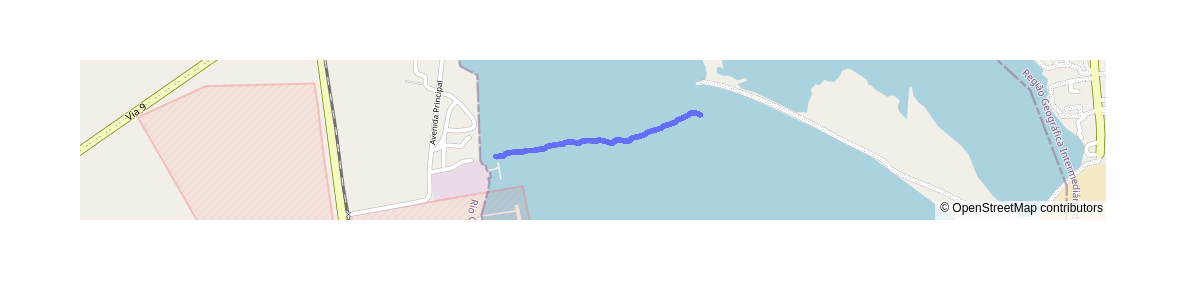

In [23]:
fig = px.scatter_mapbox(dados_df, lat="lat", lon="lon", hover_name='tempo', zoom=14, height=300)
fig.update_layout(mapbox_style="open-street-map")
#fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

# Calculando a profundidade a partir da pressão e da latitude média

In [24]:
#Convertendo pressão em profundidade
dados_df.insert(2, 'profundidade', (sw.eos80.dpth(dados_df.pressao, dados_df.lat.mean()) * -1))
#dados_df['profundidade'] = sw.eos80.dpth(dados_df.pressao, dados_df.lat.mean())

In [25]:
dados_df.head()

tempo  pressao  profundidade  temperatura  \
0 2021-02-27 07:55:15.500000-03:00   -1.245      1.236315       24.985   
1 2021-02-27 07:55:15.600000-03:00   -1.245      1.236315       24.990   
2 2021-02-27 07:55:15.700000-03:00   -1.245      1.236315       24.990   
3 2021-02-27 07:55:15.800000-03:00   -1.245      1.236315       24.989   
4 2021-02-27 07:55:15.900000-03:00   -1.245      1.236315       24.984   

   salinidade  turbidez        lat        lon  
0       0.015      1.57 -32.135247 -52.094524  
1       0.015      1.46 -32.135246 -52.094525  
2       0.015      2.37 -32.135246 -52.094525  
3       0.015      3.13 -32.135246 -52.094526  
4       0.015      3.08 -32.135246 -52.094526

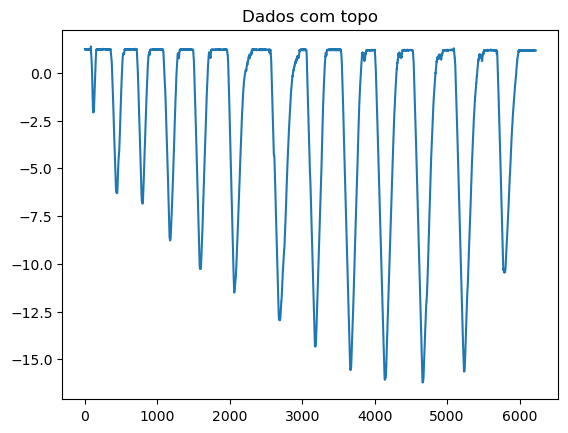

In [26]:
dados_df.profundidade.plot(title='Dados com topo');

### Filtrar os dados para retirar profundidade menores que 0,5 metros

In [27]:
# Filtrar as linhas com profundidade maior ou igual a meio metro
dados_df_st = dados_df[dados_df['profundidade'] < -0.5]

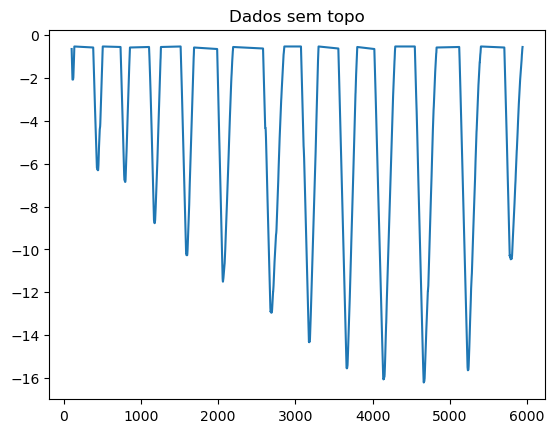

In [28]:
dados_df_st.profundidade.plot(title='Dados sem topo');

### Separar as subidas das descidas

In [29]:
dados_df_temp = dados_df_st.copy()

In [30]:
def encontrar_pontos_inflexao(dados):
    """
    Encontra os pontos de inflexão nos dados.
    
    Args:
        dados (DataFrame): DataFrame contendo os dados do CTD.
        
    Returns:
        list: Lista de índices dos pontos de inflexão.
    """
    # Inicializa a lista de índices de perfis com o primeiro índice
    indice_perfis = [0]
    
    # Itera sobre os dados para encontrar os pontos de inflexão
    for i in range(len(dados) - 1):
        if (dados.iloc[i, 3] - dados.iloc[i + 1, 3]) > 1:
            # Se a diferença entre os valores de profundidade for maior que 1,
            # considera-se um ponto de inflexão
            indice_perfis.append(i)
            indice_perfis.append(i + 1)
    
    # Adiciona o último índice
    indice_perfis.append(len(dados) - 1)
    
    return indice_perfis

def separar_perfis(dados, inicio_perfis, final_perfis):
    """
    Separa os perfis com base nos índices de início e fim dos perfis.
    
    Args:
        dados (DataFrame): DataFrame contendo os dados do CTD.
        inicio_perfis (list): Lista de índices de início dos perfis.
        final_perfis (list): Lista de índices de fim dos perfis.
        
    Returns:
        DataFrame: DataFrame contendo os perfis separados.
    """
    # Separa os perfis com base nos índices
    perfis_separados = [dados.iloc[inicio:final] for inicio, final in zip(inicio_perfis, final_perfis) if dados.iloc[inicio:final, 4].max() > (dados.iloc[inicio:final, 4].min() + 0.5)]
    
    # Concatena os perfis separados em um único DataFrame
    return pd.concat(perfis_separados)

def identificar_descida_subida(dados):
    """
    Identifica os dados de descida e subida nos perfis.
    
    Args:
        dados (DataFrame): DataFrame contendo os perfis.
        
    Returns:
        DataFrame: DataFrame contendo os dados de descida.
        DataFrame: DataFrame contendo os dados de subida.
    """
    # Identifica os dados de descida
    perfis_subida = dados[dados['profundidade'].diff() > 0.03] # esse valor controla a tolerância 
    
    # Identifica os dados de subida
    perfis_descida = dados[dados['profundidade'].diff() < -0.08] # esse valor controla a tolerância
    
    return perfis_descida, perfis_subida

In [31]:
# Encontrar pontos de inflexão
indice_perfis = encontrar_pontos_inflexao(dados_df_temp)

# Separar perfis
inicio_perfis = indice_perfis[::2]
final_perfis = indice_perfis[1::2]
perfis_separados = separar_perfis(dados_df_temp, inicio_perfis, final_perfis)

# Identificar dados de descida e subida
perfis_descida, perfis_subida = identificar_descida_subida(perfis_separados)

### Visualizando os dados separados

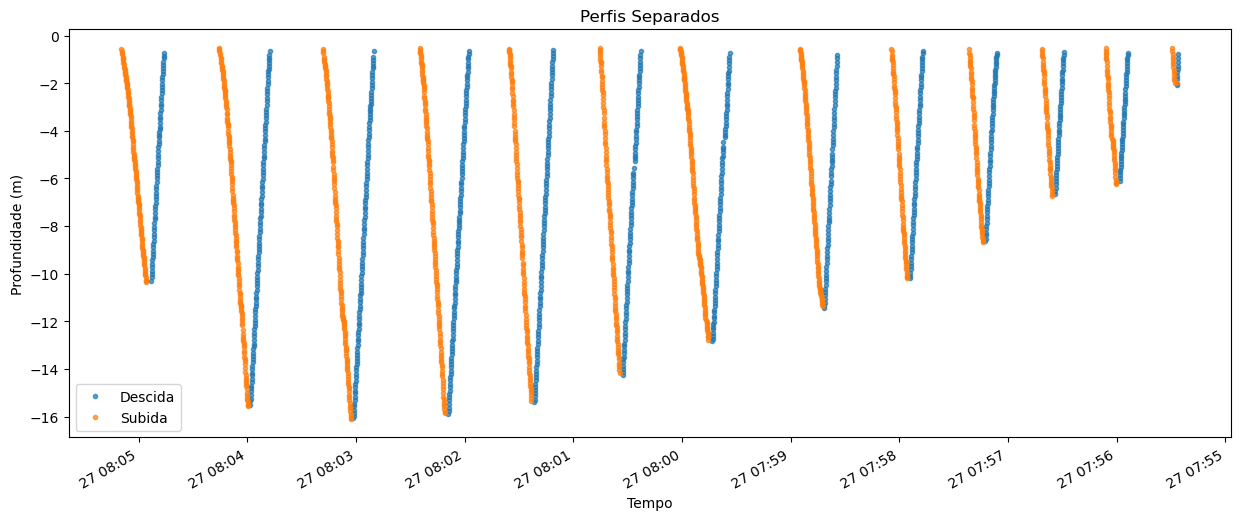

In [33]:
# Criar a figura e os eixos
fig, ax = plt.subplots(figsize=(15, 6))

# Plotar os dados de descida
perfis_descida.plot(x='tempo', y='profundidade', marker='.', linestyle='none', label='Descida', ax=ax, alpha=0.7)

# Plotar os dados de subida
perfis_subida.plot(x='tempo', y='profundidade', marker='.', linestyle='none', label='Subida', ax=ax, alpha=0.7)

# Adicionar rótulos e título ao gráfico
ax.set_xlabel('Tempo')
ax.set_ylabel('Profundidade (m)')
ax.set_title('Perfis Separados')

# Adicionar legenda
ax.legend()

# Inverter o eixo x
ax.invert_xaxis()

# Mostrar o gráfico
plt.show()

### Visualizando os perfis de descida

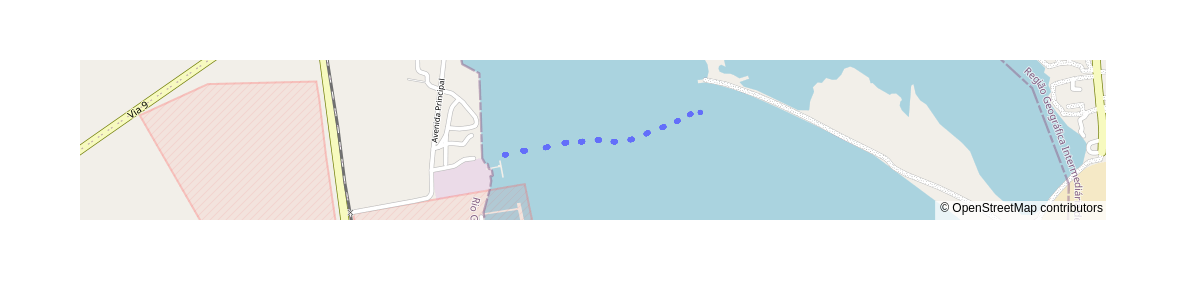

In [34]:
fig = px.scatter_mapbox(perfis_descida, lat="lat", lon="lon", hover_name='tempo', zoom=14, height=300)
fig.update_layout(mapbox_style="open-street-map")
#fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

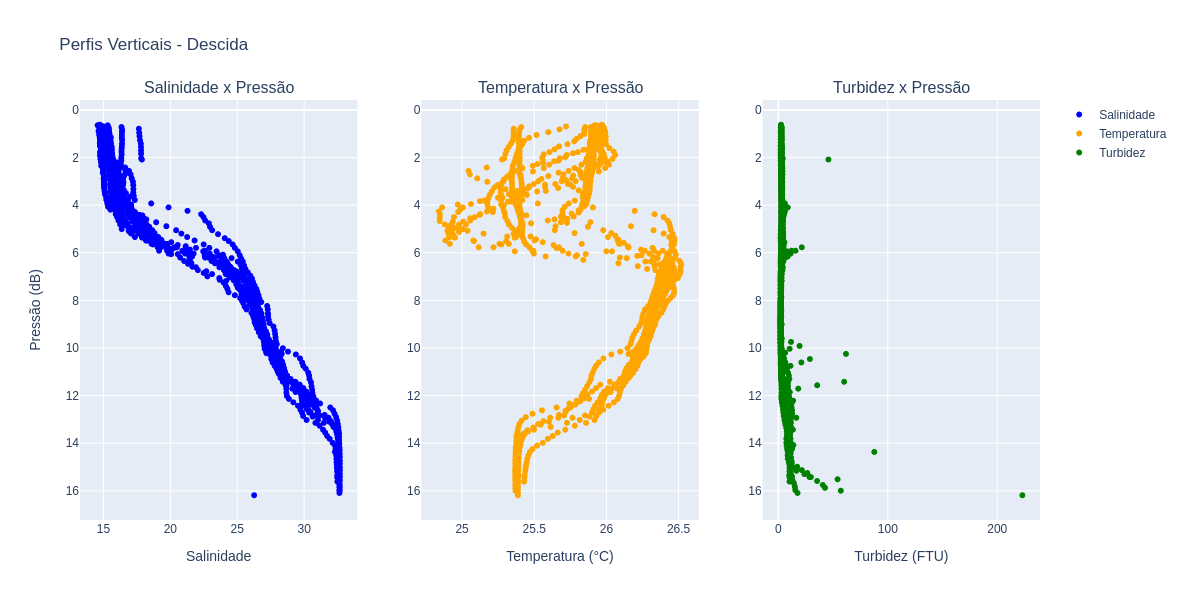

In [35]:
# Criar subplots
fig = make_subplots(rows=1, cols=3, shared_yaxes=True, subplot_titles=('Salinidade x Pressão', 'Temperatura x Pressão', 'Turbidez x Pressão'))

# Adicionar perfil de salinidade x pressão
fig.add_trace(go.Scatter(x=perfis_descida['salinidade'], y=perfis_descida['pressao'], mode='markers', name='Salinidade',
                         marker=dict(color='blue')), row=1, col=1)
fig.update_xaxes(title_text="Salinidade", row=1, col=1)
fig.update_yaxes(title_text="Pressão (dB)", autorange="reversed", row=1, col=1)

# Adicionar perfil de temperatura x pressão
fig.add_trace(go.Scatter(x=perfis_descida['temperatura'], y=perfis_descida['pressao'], mode='markers', name='Temperatura',
                         marker=dict(color='orange')), row=1, col=2)
fig.update_xaxes(title_text="Temperatura (°C)", row=1, col=2)
fig.update_yaxes(autorange="reversed", showticklabels=True, row=1, col=2)

# Adicionar perfil de turbidez x pressão
fig.add_trace(go.Scatter(x=perfis_descida['turbidez'], y=perfis_descida['pressao'], mode='markers', name='Turbidez',
                         marker=dict(color='green')), row=1, col=3)
fig.update_xaxes(title_text="Turbidez (FTU)", row=1, col=3)
fig.update_yaxes(autorange="reversed", showticklabels=True, row=1, col=3)

# Atualizar layout do gráfico
fig.update_layout(height=600, width=1000, title_text="Perfis Verticais - Descida")

# Mostrar o gráfico
fig.show()

# Calculando a distancia de um ponto projetado

In [36]:
def calcular_distancias(df, retornar_xy=False):
    """
    Calcula as distancias de cada ponto em relação a um ponto de referência na 'longitude'.

    Parâmetros:
    - df: DataFrame contendo as colunas 'lon' e 'lat' com dados de longitude e latitude, respectivamente.
    - retornar_xy: Booleano indicando se os arrays x e y devem ser retornados ou não (opcional, padrão é False).

    Retorna:
    - df: DataFrame com a coluna 'distancia' contendo as distancias calculadas em metros.
    - (opcional) x: Array numpy contendo os dados de longitude.
    - (opcional) y: Array numpy contendo os dados de latitude.
    """

    # Verificar dados ausentes
    if df[['lon', 'lat']].isnull().values.any():
        raise ValueError("Dados de latitude ou longitude ausentes.")

    # Convertendo dados de latitude e longitude para arrays de float64
    x = np.array(df.lon).astype(np.float64)
    y = np.array(df.lat).astype(np.float64)

    # Latitude média como referência para o ponto projetado
    lat_ref = np.mean(y)

    # Conversão da extensão, em km, de um grau de longitude para a latitude da área de estudo
    conversao = 111.12 * np.cos(np.radians(lat_ref))

    # Realize a regressão linear para obter os coeficientes
    coeficientes = np.polyfit(x, y, 1)
    slope = coeficientes[0]   # Inclinação da reta
    intercept = coeficientes[1]   # Interceptação com o eixo y

    # Configurando um ponto de referência na 'longitude'
    xref = x.min() - 2/conversao  # Deslocamento de aprotimadamente 2 km a oeste
    yref = intercept + slope * xref  # Calculando a 'latitude' correspondente ao ponto de referência usando o modelo linear

    ponto_projetado = (xref, yref)

    # Calculando a diferença entre os dados de Longitude e Latitude em relação ao ponto de referência
    dx = x - xref
    dy = y - yref

    # Calculando a distancia euclidiana entre cada ensemble e o ponto de referência
    # em quilômetros usando a conversão específica da latitude média dos dados
    distancia_km = (dx**2 + dy**2)**.5 * conversao

    # Ajustando a distancia para que seja em relação ao primeiro ensemble 
    # E convertendo para metros
    distancia = (distancia_km - np.min(distancia_km)) * 1000

    # Adicionando ao dataframe usando .loc para evitar o aviso
    df.loc[:, 'distancia'] = distancia

    if retornar_xy:
        return df, x, y
    else:
        return df


 ### Exemplo de uso:
#df_processado = calcular_distancias(df)
 ### Ou, para retornar também os arrays x e y:
#df_processado, x_array, y_array = calcular_distancias(df, retornar_xy=True)

In [39]:
# Aplica a função
df_processado, x_array, y_array = calcular_distancias(perfis_descida, retornar_xy=True)

In [40]:
# Realize a regressão linear para obter os coeficientes
coeficientes = np.polyfit(x_array, y_array, 1)

# Cria a função polinomial com base nos coeficientes da regressão linear
reta_regressao = np.poly1d(coeficientes)

# Cria uma linha representando a reta de regressão
# E estende a linha de regressão além dos pontos etistentes
x_ext = np.linspace(min(x_array)-0.05, max(x_array)+0.05, 100)  # 100 pontos para a extensão
y_ext = reta_regressao(x_ext)
linha_regressao = LineString(list(zip(x_ext, y_ext)))

# Crie um GeoDataFrame para armazenar as geometrias
geometry = [Point(lon, lat) for lat, lon in zip(y_array, x_array)]
gdf = gpd.GeoDataFrame(geometry=geometry)

# Latitude média como referência para o ponto projetado
lat_ref = np.mean(y_array)

# Conversão da extensão, em km, de um grau de longitude para a latitude da área de estudo
# 111.12 km é a extensão de um grau de longitude no equador (40000km / 360graus)
conversao = 111.12 * np.cos(np.radians(lat_ref))

# Configurando um ponto de referência na 'longitude'
xref = x_array.min() - 2/conversao  # Deslocamento de aprotimadamente 2 km a oeste
slope = coeficientes[0]   # Inclinação da reta
intercept = coeficientes[1]   # Interceptação com o eixo y
yref = intercept + slope * xref  # Calculando a 'latitude' correspondente ao ponto de referência usando o modelo linear

ponto_projetado = (xref, yref)

# Crie um GeoDataFrame para o ponto projetado
gdf_ponto = gpd.GeoDataFrame(geometry=[Point(ponto_projetado)])

# Crie um GeoDataFrame para a linha de regressão
gdf_linha = gpd.GeoDataFrame(geometry=[linha_regressao])

### Visualizando a Reta de Regressão e o Ponto no Mapa

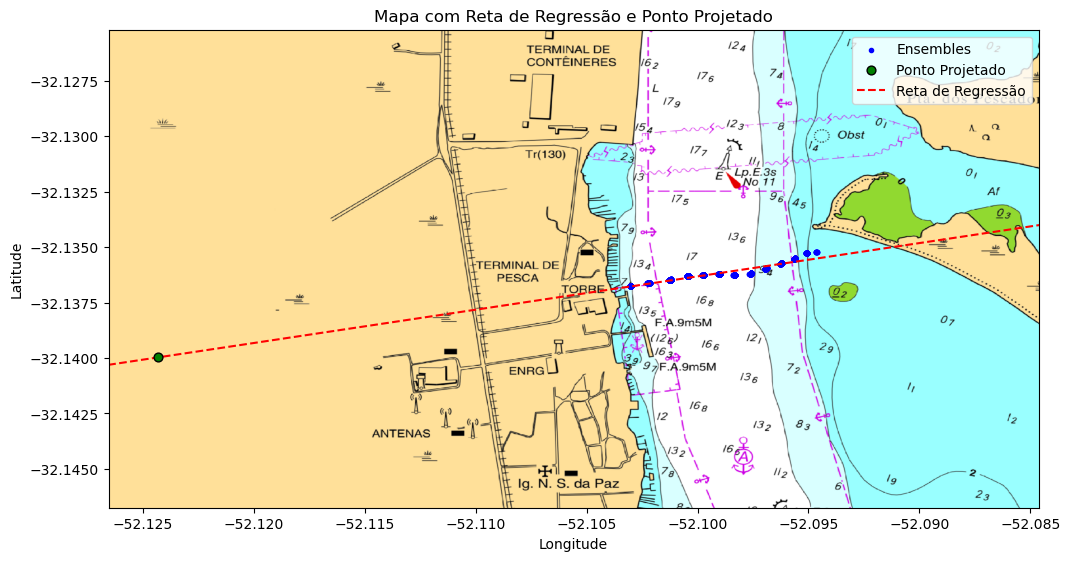

In [41]:
# Plote a nuvem de pontos, a reta de regressão e o ponto projetado
fig, ax = plt.subplots(figsize=(12, 8))
gdf.plot(ax=ax, marker='.', color='blue', label='Ensembles')
gdf_ponto.plot(ax=ax, marker='o', color='g', label='Ponto Projetado', zorder=3, markersize=40, edgecolors='black')
gdf_linha.plot(ax=ax, color='red', linestyle='--', label='Reta de Regressão')

# Adiciona rótulos e legendas
plt.title('Mapa com Reta de Regressão e Ponto Projetado')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

# Dê um zoom out ajustando os limites do gráfico
ax.set_xlim(min(x_array)-0.0235, max(x_array)+0.01)
ax.set_ylim(min(y_array)-0.01, max(y_array)+0.01)

# Mostre o basemap
show(basemap, ax=ax, cmap='Blues')

# Etiba o mapa
plt.show()

### Plot - Identificando Outliers Graficamente

In [42]:
# fig, ax = plt.subplots(figsize=(25, 10), dpi=300)
# scatter = ax.scatter(df_processado['distancia'], df_processado['profundidade'], c=df_processado['salinidade'], cmap='jet')

# plt.title('Salinidade - orientação oeste > leste')
# plt.colorbar(scatter, label='Salinidade')

# ax.set_xlabel('distancia (m)')
# ax.set_ylabel('Profundidade (m)')

# plt.rcParams.update({'font.size': 18})  # Ajuste o tamanho da fonte conforme necessário

# plt.show()


In [43]:
df_processado.turbidez.nlargest(10)

4659    222.99
3173     87.66
1585     61.73
4624     60.08
4135     57.05
3660     54.08
114      45.69
4134     42.58
4133     40.60
4625     35.46
Name: turbidez, dtype: float64

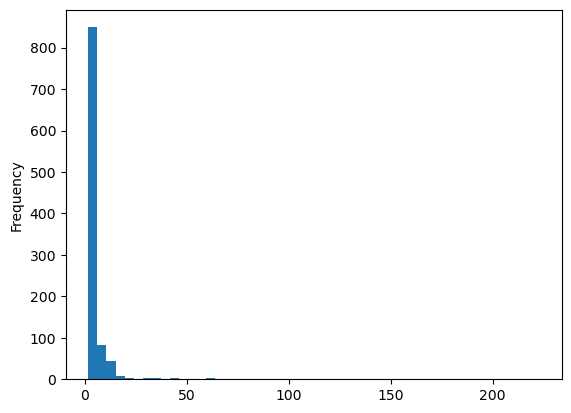

In [44]:
df_processado.turbidez.plot.hist(bins=50);

In [45]:
# Filtrar as linhas com profundidade maior ou igual a meio metro
df_processado = df_processado[df_processado['turbidez'] < 15]

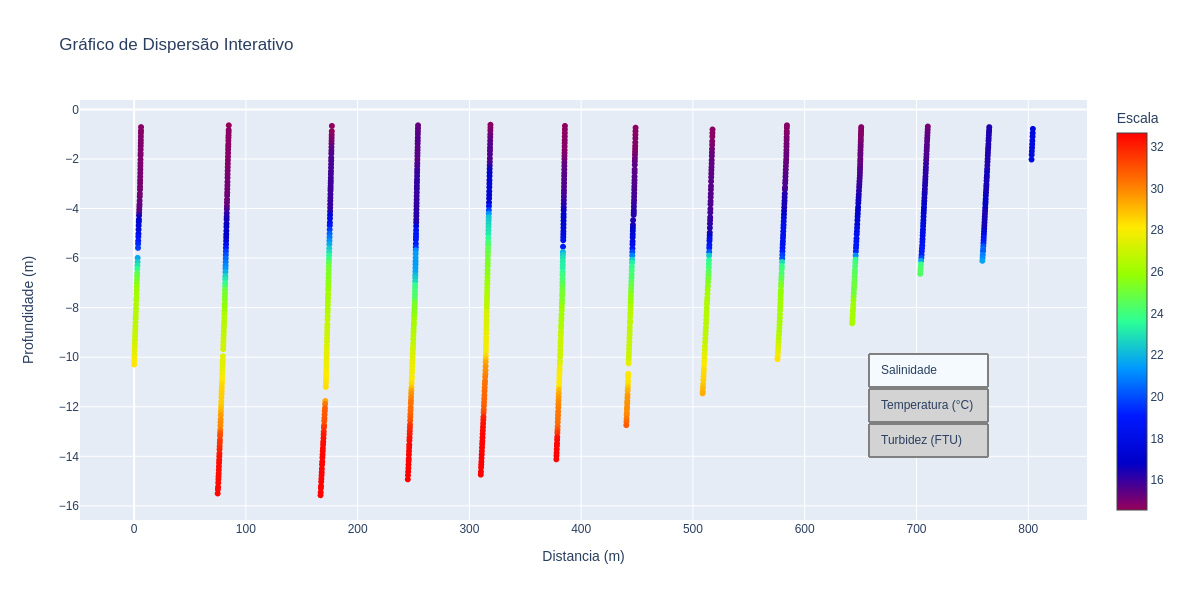

In [46]:
# Dados iniciais
dados_x = df_processado['distancia']
dados_y = df_processado['profundidade']
dados_z = df_processado['salinidade']  # Começa com salinidade como cor padrão

# Criar a figura inicial
fig = go.Figure(data=go.Scatter(x=dados_x, y=dados_y, mode='markers',
                                marker=dict(color=dados_z, colorscale='Rainbow', colorbar=dict(title='Escala')),
                                text=['Salinidade: {:.2f}<br>Temperatura: {:.2f}<br>Turbidez: {:.2f}'.format(s, t, u) 
                                      for s, t, u in zip(df_processado['salinidade'], df_processado['temperatura'], df_processado['turbidez'])]))

# Adicionar título e rótulos dos eixos
fig.update_layout(title='Gráfico de Dispersão Interativo',
                  xaxis_title='Distancia (m)',
                  yaxis_title='Profundidade (m)')

# Definir botões para alternar entre as variáveis de cor
buttons = []
for nome, dados_cor in [('Salinidade', df_processado['salinidade']),
                        ('Temperatura (°C)', df_processado['temperatura']),
                        ('Turbidez (FTU)', df_processado['turbidez'])]:
    botao = dict(label=nome,
                  method="update",
                  args=[{"marker.color": [dados_cor]},
                        {"marker.colorbar.title.text": nome}])
    buttons.append(botao)

# Adicionar botões para alternar as variáveis de cor
fig.update_layout(
    updatemenus=[
        dict(
            type="buttons",
            direction="down",
            buttons=buttons,
            x=0.9,
            xanchor='right',
            y=0.4,
            yanchor='top',
            # Destacar o botão selecionado
            showactive=True,
            bgcolor='lightgrey',  # Cor de fundo para o botão selecionado
            bordercolor='grey',   # Cor do contorno do botão selecionado
            borderwidth=2         # Largura do contorno do botão selecionado
        )
    ]
)

# Mudar as dimensões da figura
fig.update_layout(width=1000, height=600)

fig.update_xaxes(showspikes=True, spikecolor="black", spikethickness=2)
fig.update_yaxes(showspikes=True, spikecolor="black", spikethickness=2)

# Etibir o gráfico
fig.show()


# Interpolando

In [47]:
# Definir a grade para interpolação
di = np.linspace(df_processado['distancia'].min(), df_processado['distancia'].max(), 41)
pi = np.linspace(df_processado['profundidade'].min(), df_processado['profundidade'].max(), 50)
dd, pp = np.meshgrid(di, pi)


points = np.array([df_processado['distancia'], df_processado['profundidade']]).T
# Interpolar os dados de salinidade
sal_i = griddata(points, df_processado['salinidade'], (dd, pp), method='linear', rescale=True)

# Interpolar os dados de temperatura
temp_i = griddata(points, df_processado['temperatura'], (dd, pp), method='linear', rescale=True)

# Interpolar os dados de turbidez
turb_i = griddata(points, df_processado['turbidez'], (dd, pp), method='linear', rescale=True)

### Visualizando dados interpolados

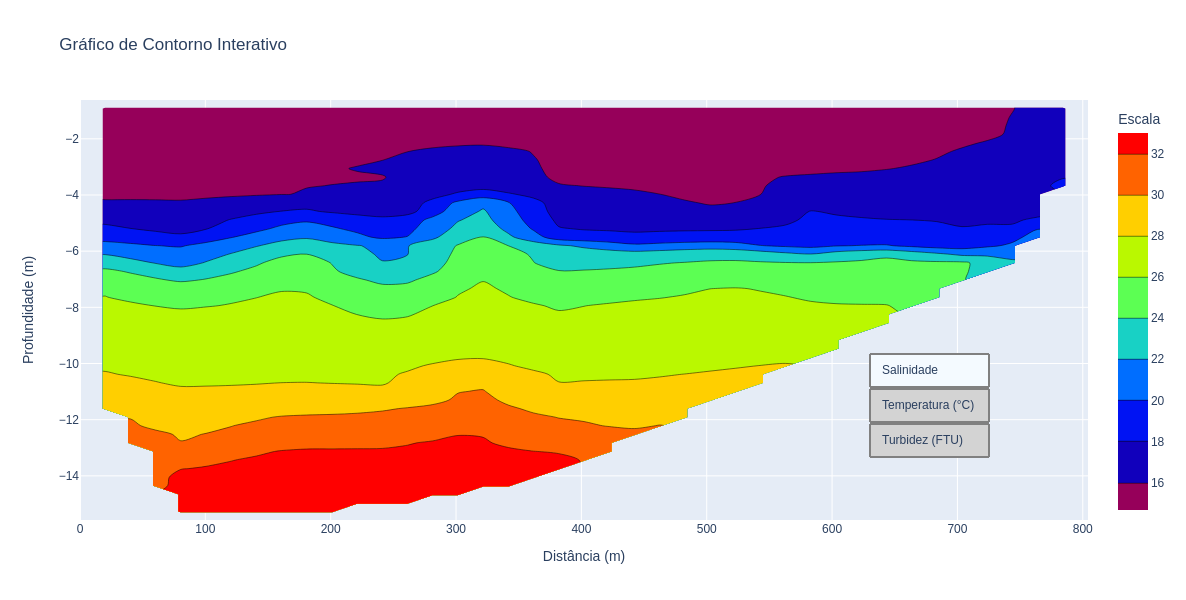

In [49]:
# Empilhar temp_i e turb_i ao longo do novo eixo (eixo 2)
customdata = np.stack((temp_i, turb_i), axis=2)

# Criar o gráfico de contorno inicial
fig = go.Figure(data=go.Contour(z=sal_i, x=di, y=pi, 
                                customdata=customdata,
                                line_smoothing=0.85,
                                colorscale='Rainbow',
                                colorbar=dict(title='Escala'),
                                hovertemplate ="Distância: %{x:.2f}m"+\
                                               "<br>Profundidade: %{y:.2f}m"+\
                                               "<br>Salinidade: %{z:.2f}"+\
                                               "<br>Temperatura: %{customdata[0]:.2f}°C"+\
                                               "<br>Turbidez: %{customdata[1]:.2f}FTU<extra></extra>"))

#hovertemplate='Distância: %{x} m<br>Profundidade: %{y} m<br>Salinidade: %{z:.2f} psu '))

# Adicionar título e rótulos dos eixos
fig.update_layout(title='Gráfico de Contorno Interativo',
                  xaxis_title='Distância (m)',
                  yaxis_title='Profundidade (m)')

# Definir botões para alternar entre as variáveis de cor
buttons = [
    dict(label="Salinidade",
         method="update",
         args=[{"z": [sal_i]},
               {"colorbar.title.text": "Salinidade"}]),
    dict(label="Temperatura (°C)",
         method="update",
         args=[{"z": [temp_i]},
               {"colorbar.title.text": "Temperatura"}]),
    dict(label="Turbidez (FTU)",
         method="update",
         args=[{"z": [turb_i]},
               {"colorbar.title.text": "Turbidez"}])
]


# Adicionar botões para alternar as variáveis de cor
fig.update_layout(
    updatemenus=[
        dict(
            type="buttons",
            direction="down",
            buttons=buttons,
            x=.9,
            xanchor='right',
            y=.4,
            yanchor='top',
            
            # Destacar o botão selecionado
            showactive=True,
            bgcolor='lightgrey',  # Cor de fundo para o botão selecionado
            bordercolor='grey',   # Cor do contorno do botão selecionado
            borderwidth=2         # Largura do contorno do botão selecionado
        )
    ]
)

# Mudar as dimensões da figura
fig.update_layout(width=1000, height=600)


fig.update_xaxes(showspikes=True, spikecolor="black", spikethickness=2)
fig.update_yaxes(showspikes=True, spikecolor="black", spikethickness=2)

# Etibir o gráfico
fig.show()
